## **Notebook para implementar la regresión con minimización del MAPE.**

Importar librerías que se usarán en el análisis.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import (linear_kernel,rbf_kernel)
import cvxpy as cp #https://www.cvxpy.org/
from sklearn.metrics import mean_squared_error

In [2]:
#%% Generate X data points
def genX(lmin=0,lmax=20,npoints=29):
    x1 = np.linspace(lmin,lmax,npoints)
    x2 = np.linspace(lmin,lmax,npoints)
    X1,X2 = np.meshgrid(x1,x2)
    x1m = np.ravel(X1.T)
    x2m = np.ravel(X2.T)
    Xm = np.c_[x1m,x2m]
    return Xm

In [3]:
#%% Test function 1 (Hyperplane)
def testfunction1(X,noise=False):
    # Modelo: Y = 2*X1+3*X2+40
    X1 = X[:,0]
    X2 = X[:,1]
    if noise:
        Y = 2*X1+3*X2+40+(5*np.random.rand(X.shape[0])-2.5)
    else:
        Y = 2*X1+3*X2+40
    
    y = np.ravel(Y.T)
    return y

In [4]:
#%% Test function 2
def testfunction2(X,noise=False):
    # Modelo: Y = 500+(x1^2-x2^2)*sin(0.5*x1)+10
    X1 = X[:,0]
    X2 = X[:,1]
    X1 = X1-(max(X1)+min(X1))/2
    X2 = X2-(max(X2)+min(X2))/2
    if noise:
        Y = 100+(X1**2-X2**2)*np.sin(0.5*X1)+(5*np.random.rand(X.shape[0])-2.5)
    else:
        Y = 100+(X1**2-X2**2)*np.sin(0.5*X1)
    
    y = np.ravel(Y.T)
    return y

In [5]:
#%% Test function 3
def testfunction3(X,noise=False):
    # Modelo: Y = sin(sqrt(x1^2+x2^2))/sqrt(x1^2+x2^2)+10
    X1 = X[:,0]
    X2 = X[:,1]
    X1 = X1-(max(X1)+min(X1))/2
    X2 = X2-(max(X2)+min(X2))/2
    den = np.sqrt(X1**2+X2**2)
    den[den==0]=0.001
    if noise:
        Y = 10+np.sin(np.sqrt(X1**2+X2**2))/den+(0.5*np.random.rand(X.shape[0])-0.25)
    else:
        Y = 10+np.sin(np.sqrt(X1**2+X2**2))/den
    
    y = np.ravel(Y.T)
    return y

In [6]:
#%% Test function 4
def testfunction4(X,noise=False):
    # Modelo: Y = x1^2+x2^2-np.cos(2*x1)-np.cos(2*x2)+10
    X1 = X[:,0]
    X2 = X[:,1]
    X1 = X1-(max(X1)+min(X1))/2
    X2 = X2-(max(X2)+min(X2))/2
    if noise:
        Y = 10+X1**2+X2**2-10*np.cos(2*X1)-10*np.cos(2*X2)+(5*np.random.rand(X.shape[0])-2.5)
    else:
        Y = 10+X1**2+X2**2-10*np.cos(2*X1)-10*np.cos(2*X2)
    
    y = np.ravel(Y.T)
    return y

Generación de los datos a analizar. Los datos contienen 2 predictores (x1,x2), las cuales se relacionan por medio de una función del tipo Y = 2*X1+3*X2+40. Ha esos datos se le agregan valores aleatorios para evitar que sea un ajuste perfecto.

In [7]:
np.random.seed(1)
lmin = 1
lmax = 20
n = 29
Xm = genX(lmin=lmin,lmax=lmax,npoints=n)
#y = testfunction1(X=Xm,noise=False)
#y = testfunction2(X=Xm,noise=False)
y = testfunction3(X=Xm,noise=False)
#y = testfunction4(X=Xm,noise=False)

Visualizar los datos

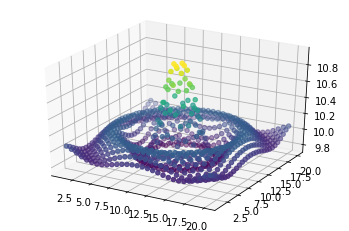

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xm[:,0], Xm[:,1], y, c=y)
plt.show()

Declaración de la funciones que se usarán

In [9]:
# Funcion MAPE
def mean_absolute_percentage_error(y_true,y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [10]:
#%% Custom kernel function
def custom_kernel(X1,X2,kernel='linear',gamma=None,lck=1):
    # Kernel matrix
    if kernel == 'linear':
        K = linear_kernel(X1,X2)
    elif kernel == 'rbf':
        K = rbf_kernel(X1,X2,gamma=gamma)
    elif kernel == 'linrbf':
        K = lck*linear_kernel(X1,X2)+(1-lck)*rbf_kernel(X1,X2,gamma=gamma)
    return K

In [11]:
#%% Simulacion del modelo de regresion
def sim_modelo(X,params):
    K_sv = custom_kernel(params[0],X,kernel=params[3],gamma=params[4],lck=params[5])
    y = np.dot(params[1],K_sv)+params[2]
    return y

In [12]:
# Optimization classic E-regression with cvxpy
def SVR_E(X,y,epsilon=0.01,c=10,kernel='linear',gamma=None,lck=1):
    # epsilon = 0.01 # margin max
    # c = 10 # alphas constraint
    # kernel = 'linear' # kernel type, options: ('linear','rbf','linrbf')
    # gamma = None # gamma parameter for rbf-kernel and linrbf-kernel
    # lck = 1 # constant for kernel linear combination, 0<=lck<=1
    
    umbral = 1E-5 # umbral to define a vector support
    
    nsamples,nfeatures = np.shape(X)
    onev = np.ones((nsamples,1))
    
    # Kernel matrix
    K = custom_kernel(Xm,Xm,kernel=kernel,gamma=gamma,lck=lck)

    # Optimization E-regression
    alpha1 = cp.Variable((nsamples,1))
    alpha2 = cp.Variable((nsamples,1))
    
    Ev = onev*epsilon
    objective = cp.Minimize((1/2)*cp.quad_form(alpha1-alpha2, K) + Ev.T @ (alpha1+alpha2) - y.T @ (alpha1 - alpha2))
    
    # Constrains in matrix form
    G = np.float64(np.concatenate((np.identity(nsamples),-np.identity(nsamples))))
    h = np.float64(np.concatenate((c*np.ones((nsamples,1)),np.zeros((nsamples,1)))))
    
    constraints = [onev.T @ (alpha1-alpha2) == 0, G @ alpha1 <= h, G @ alpha2 <= h]
    
    # The optimal objective value is returned by `prob.solve()`.
    prob = cp.Problem(objective,constraints)
    result = prob.solve()
    
    alpha1 = np.array(alpha1.value)
    alpha2 = np.array(alpha2.value)
    alphas = alpha1-alpha2
    indx = abs(alphas) > umbral
    alpha_sv = alphas[indx]
    x_sv = X[indx[:,0],:]
    y_sv = y[indx[:,0]]
    
    
    # Coef0 obtention
    b = np.mean(y_sv-np.dot(alpha_sv,custom_kernel(x_sv,x_sv,kernel=kernel,gamma=gamma,lck=lck)))
    
    return x_sv,alpha_sv,b,kernel,gamma,lck

In [13]:
# Optimization E-regression MAPE with cvxpy
def SVR_E_MAPE(X,y,epsilon=0.01,c=10,kernel='linear',gamma=None,lck=1):
    # epsilon = 0.01 # margin max
    # c = 10 # alphas constraint
    # kernel = 'linear' # kernel type, options: ('linear','rbf','linrbf')
    # gamma = None # gamma parameter for rbf-kernel and linrbf-kernel
    # lck = 1 # constant for kernel linear combination, 0<=lck<=1
    umbral = 1E-5 # umbral to define a vector support
    
    nsamples,nfeatures = np.shape(X)
    onev = np.ones((nsamples,1))
    
    # Kernel matrix
    K = custom_kernel(Xm,Xm,kernel=kernel,gamma=gamma,lck=lck)
    
    # Optimization E-regression with MAPE
    alpha1 = cp.Variable((nsamples,1))
    alpha2 = cp.Variable((nsamples,1))
    
    Ev = np.reshape(y,(nsamples,1))*epsilon
    objective = cp.Minimize((1/2)*cp.quad_form(alpha1-alpha2, K) + Ev.T @ (alpha1+alpha2) - y.T @ (alpha1 - alpha2))
    
    # Constrains in matrix form
    G = np.float64(np.concatenate((np.identity(nsamples),-np.identity(nsamples))))
    h=np.float64(np.concatenate((c/np.reshape(y,(nsamples,1)),np.zeros((nsamples,1)))))
    constraints = [onev.T @ (alpha1-alpha2) == 0, G @ alpha1 <= h, G @ alpha2 <= h]
    
    # The optimal objective value is returned by `prob.solve()`.
    prob = cp.Problem(objective,constraints)
    result = prob.solve()
    
    
    alpha1 = np.array(alpha1.value)
    alpha2 = np.array(alpha2.value)
    alphas = alpha1-alpha2
    indx = abs(alphas) > umbral
    alpha_sv = alphas[indx]
    x_sv = X[indx[:,0],:]
    y_sv = y[indx[:,0]]
    
    # Coef0 obtention
    b = np.mean(y_sv-np.dot(alpha_sv,custom_kernel(x_sv,x_sv,kernel=kernel,gamma=gamma,lck=lck)))
    
    return x_sv,alpha_sv,b,kernel,gamma,lck


In [14]:
#%% Optimization classic v formulation E-regression with cvxpy
def SVR_vE(X,y,epsilon=0.01,c=10,v=1,kernel='linear',gamma=None,lck=1):
    #    epsilon = 0.01 # margin max
    #    v = 1 # New term
    #    c = 10 # alphas constraint
    # kernel = 'linear' # kernel type, options: ('linear','rbf','linrbf')
    # gamma = None # gamma parameter for rbf-kernel and linrbf-kernel
    # lck = 1 # constant for kernel linear combination, 0<=lck<=1
    
    umbral = 1E-5 # vector support 
    nsamples,nfeatures = np.shape(X)
    onev = np.ones((nsamples,1))
    
    # Kernel matrix
    K = custom_kernel(Xm,Xm,kernel=kernel,gamma=gamma,lck=lck)
    
    # Optimization formulation vE-regression 
    alpha1 = cp.Variable((nsamples,1))
    alpha2 = cp.Variable((nsamples,1))
    
    objective = cp.Minimize((1/2)*cp.quad_form(alpha1-alpha2, K) - y.T @ (alpha1 - alpha2))
    
    # Restricciones forma matricial
    G = np.float64(np.concatenate((np.identity(nsamples),-np.identity(nsamples))))
    h = np.float64(np.concatenate((c*np.ones((nsamples,1)),np.zeros((nsamples,1)))))
    
    constraints = [onev.T @ (alpha1-alpha2) == 0,
                   onev.T @ (alpha1+alpha2) == c*v,
                   G @ alpha1 <= h,
                   G @ alpha2 <= h]
    
    # The optimal objective value is returned by `prob.solve()`.
    prob = cp.Problem(objective,constraints)
    result = prob.solve()
    
    alpha1 = np.array(alpha1.value)
    alpha2 = np.array(alpha2.value)
    alphas = alpha1-alpha2
    indx = abs(alphas) > umbral
    alpha_sv = alphas[indx]
    x_sv = X[indx[:,0],:]
    y_sv = y[indx[:,0]]
    
    # Coef0 obtention
    b = np.mean(y_sv-np.dot(alpha_sv,custom_kernel(x_sv,x_sv,kernel=kernel,gamma=gamma,lck=lck)))
    
    return x_sv,alpha_sv,b,kernel,gamma,lck

In [15]:
#%% Optimization v formulation MAPE-regression usando cvxpy
def SVR_vMAPE(X,y,epsilon=0.01,c=10,v=1,kernel='linear',gamma=None,lck=1):
    #    epsilon = 0.01 # margin max
    #    v = 1 # New term
    #    c = 10 # alphas constraint
    # kernel = 'linear' # kernel type, options: ('linear','rbf','linrbf')
    # gamma = None # gamma parameter for rbf-kernel and linrbf-kernel
    # lck = 1 # constant for kernel linear combination, 0<=lck<=1
    
    umbral = 1E-5 # vector support 
    nsamples,nfeatures = np.shape(X)
    onev = np.ones((nsamples,1))
    
    # Kernel matrix
    K = custom_kernel(Xm,Xm,kernel=kernel,gamma=gamma,lck=lck)
    
    # Optimization formulation vE-regression with MAPE
    alpha1 = cp.Variable((nsamples,1))
    alpha2 = cp.Variable((nsamples,1))
    
    objective = cp.Minimize((1/2)*cp.quad_form(alpha1-alpha2, K) - y.T @ (alpha1 - alpha2))
    
    # Restricciones forma matricial
    G = np.float64(np.concatenate((np.identity(nsamples),-np.identity(nsamples))))
    h=np.float64(np.concatenate((100*c/np.reshape(y,(nsamples,1)),np.zeros((nsamples,1)))))
    constraints = [onev.T @ (alpha1-alpha2) == 0,
                   (y/100).T @ (alpha1+alpha2) == c*v,
                   G @ alpha1 <= h,
                   G @ alpha2 <= h]
    
    # The optimal objective value is returned by `prob.solve()`.
    prob = cp.Problem(objective,constraints)
    result = prob.solve()
    
    alpha1 = np.array(alpha1.value)
    alpha2 = np.array(alpha2.value)
    alphas = alpha1-alpha2
    indx = abs(alphas) > umbral
    alpha_sv = alphas[indx]
    x_sv = X[indx[:,0],:]
    y_sv = y[indx[:,0]]
    
    # Coef0 obtention
    b = np.mean(y_sv-np.dot(alpha_sv,custom_kernel(x_sv,x_sv,kernel=kernel,gamma=gamma,lck=lck)))
    
    return x_sv,alpha_sv,b,kernel,gamma,lck

Aplicación de la regresión usando la aproximación Epsilon

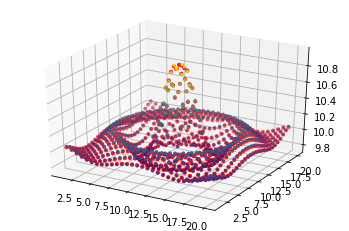

In [16]:
#%% Aplicar la regresion epsilon
# Parameters values
#   epsilon default: 0.1, epsilon>0
#   c default: 10, c>0
#   kernel default: 'linear', other values ('rbf','linrbf')
#   gamma default: None, other values gamma>0
#   lck default: 1 (linear kernel), other values 0<=lck<=1

# kernel = 'linear' # kernel type selection
# lck = 1 # constant to kernel linear combination
# gamma = None # parameter

params_E = SVR_E(Xm,y,epsilon=0.01,c=10,kernel='rbf',gamma=None,lck=1)

#% Simular el modelo
y_Ereg = sim_modelo(Xm,params_E)


#% Visualizar los resultados
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xm[:,0], Xm[:,1], y, c=y,s=5)
ax.scatter(Xm[:,0], Xm[:,1], y_Ereg, c='r',s=10)
#ax.view_init(30, 0)
plt.show()

Aplicación de la regresión usando la aproximación Epsilon con MAPE

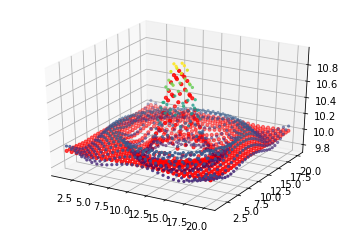

In [17]:
#%% Aplicar la regresion epsilon MAPE
params_Emape = SVR_E_MAPE(Xm,y,epsilon=0.01,c=10,kernel='rbf',gamma=None,lck=1)

#% Simular el modelo
y_mape = sim_modelo(Xm,params_Emape)

#% Visualizar los resultados
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xm[:,0],Xm[:,1], y, c=y,s=5)
ax.scatter(Xm[:,0],Xm[:,1], y_mape, c='r',s=10)
#ax.view_init(30, 0)
plt.show()

Aplicación de la regresión usando la aproximación clásica vEpsilon

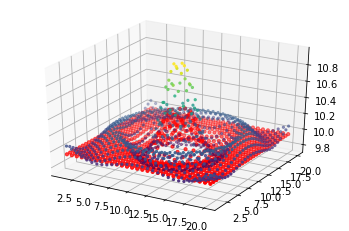

In [18]:
#%% Aplicar la regresion epsilon con formulacion v
params_vE = SVR_vE(Xm,y,epsilon=0.01,c=10,v=1,kernel='rbf',gamma=None,lck=1)

#% Simular el modelo
y_vE = sim_modelo(Xm,params_vE)

#% Visualizar los resultados
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xm[:,0],Xm[:,1], y, c=y,s=5)
ax.scatter(Xm[:,0],Xm[:,1], y_vE, c='r',s=10)
#ax.view_init(30, 0)
plt.show()

Aplicación de la regresión usando la aproximación vEpsilon con MAPE

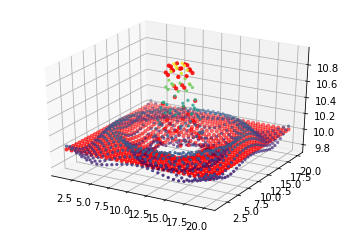

In [20]:
#%% Aplicar la regresion epsilon con formulacion v
params_vmape = SVR_vMAPE(Xm,y,epsilon=0.01,c=10,v=1,kernel='rbf',gamma=None,lck=1)

#% Simular el modelo
y_vmape = sim_modelo(Xm,params_vmape)

#% Visualizar los resultados
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xm[:,0],Xm[:,1], y, c=y,s=5)
ax.scatter(Xm[:,0],Xm[:,1], y_vmape, c='r',s=10)
#ax.view_init(30, 0)
plt.show()

Evaluacion de ambas implementaciones

In [21]:
rmse_ereg,mape_ereg = mean_squared_error(y,y_Ereg),mean_absolute_percentage_error(y,y_Ereg)
rmse_mape,mape_mape = mean_squared_error(y,y_mape),mean_absolute_percentage_error(y,y_mape)
rmse_vE,mape_vE = mean_squared_error(y,y_vE),mean_absolute_percentage_error(y,y_vE)
rmse_vmape,mape_vmape = mean_squared_error(y,y_vmape),mean_absolute_percentage_error(y,y_vmape)

In [22]:
print('\n\n\t\t\t RMSE\t\t MAPE\n Formulation Ereg\t %0.4f\t\t %0.4f\n Formulation Emape\t %0.4f\t\t %0.4f\n Formulation vE\t\t %0.4f\t\t %0.4f\n Formulation vmape\t %0.4f\t\t %0.4f'%(rmse_ereg,mape_ereg,rmse_mape,mape_mape,rmse_vE,mape_vE,rmse_vmape,mape_vmape))



			 RMSE		 MAPE
 Formulation Ereg	 0.0011		 0.0917
 Formulation Emape	 0.0065		 0.6579
 Formulation vE		 0.0149		 0.8773
 Formulation vmape	 0.0099		 0.8440
